**Import**

In [19]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

**Dataset**

In [20]:
from google.colab import drive
drive.mount('/content/drive')
data_folder = "/content/drive/My Drive/cifar-10-batches-py"

def training_set():
    training_images = []
    training_labels = []
    for batch in range(5):
        file = f'{data_folder}/data_batch_{batch + 1}'
        with open(file, 'rb') as fo:
            data_batch = pickle.load(fo, encoding='bytes')

        image_batch_raw = data_batch[b'data']
        labels_batch = data_batch[b'labels']

        for id, image in enumerate(image_batch_raw):
            red_channel = image[:1024].reshape(32, 32)     # Red values
            green_channel = image[1024:2048].reshape(32, 32)  # Green values
            blue_channel = image[2048:].reshape(32, 32)    # Blue values

            # Stack the channels along the last axis to create a (32, 32, 3) image
            final_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

            # Append the reshaped image to the training set
            training_images.append(final_image)
            training_labels.append(labels_batch[id])
    training_images = np.stack(training_images, axis=0)
    training_labels = np.stack(training_labels, axis=0)
    return training_images, training_labels

def test_set():
    training_images = []
    training_labels = []

    file = f'{data_folder}/test_batch'
    with open(file, 'rb') as fo:
        data_batch = pickle.load(fo, encoding='bytes')

    image_batch_raw = data_batch[b'data']
    labels_batch = data_batch[b'labels']

    for id, image in enumerate(image_batch_raw):
        red_channel = image[:1024].reshape(32, 32)     # Red values
        green_channel = image[1024:2048].reshape(32, 32)  # Green values
        blue_channel = image[2048:].reshape(32, 32)    # Blue values

        # Stack the channels along the last axis to create a (32, 32, 3) image
        final_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

        # Append the reshaped image to the training set
        training_images.append(final_image)
        training_labels.append(labels_batch[id])
    training_images = np.stack(training_images, axis=0)
    training_labels = np.stack(training_labels, axis=0)
    return training_images, training_labels

with open(f'{data_folder}/batches.meta', 'rb') as fo:
    info = pickle.load(fo, encoding='bytes')
label_names = info[b'label_names']

X_train, y_train = training_set()
X_test, y_test = test_set()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


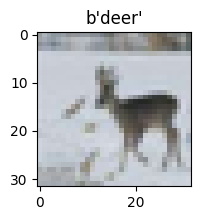

In [21]:
def visualize(image, label):
    label = label_names[np.argmax(label)]
    plt.figure(figsize=(2, 2))
    plt.subplot(1, 1, 1), plt.imshow(image), plt.title(label)
    plt.show()
    return

i = 20
visualize(X_train[i], y_train[i])

**VGG-16 model**

In [22]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = Sequential([base_model,
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dropout(0.5),
                    Dense(10, activation='softmax')])

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

print("Evaluating the pre-trained model on the test set:")
initial_loss, initial_acc = model.evaluate(X_test, y_test, verbose=2)

Evaluating the pre-trained model on the test set:
313/313 - 5s - 15ms/step - accuracy: 0.1031 - loss: 2.5044


**Training Process**

In [23]:
# Set up model checkpoint to save weights after every epoch
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/temp/VGG_checkpoints.keras',  # Filepath to save the model
    save_weights_only=False,           # Save only the model weights
    save_best_only=False,             # Save every epoch (not just the best one)
    verbose=1
)

In [24]:
EPOCHS = 30


# Train the model and save the checkpoints
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,                       # Number of epochs
    batch_size=64,
    callbacks=[checkpoint_callback]   # Save the model checkpoints
)

with open("/content/drive/My Drive/temp/training_history.pkl", 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3939 - loss: 1.7088
Epoch 1: saving model to /content/drive/My Drive/temp/VGG_checkpoints.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.3940 - loss: 1.7086 - val_accuracy: 0.5545 - val_loss: 1.2809
Epoch 2/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5366 - loss: 1.3215
Epoch 2: saving model to /content/drive/My Drive/temp/VGG_checkpoints.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5367 - loss: 1.3214 - val_accuracy: 0.5706 - val_loss: 1.2238
Epoch 3/30
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5627 - loss: 1.2446
Epoch 3: saving model to /content/drive/My Drive/temp/VGG_checkpoints.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5627 - loss: 1.2446 - val_accuracy: 0.5891 - val_loss: 1.1848
Epoch 4/30
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5765 - loss: 1.2049
Epoch 4: saving model to /content/drive/My Drive/temp/VGG_checkpoin

**Finetune** \\
*can also be used to resuming training after interuption*

In [25]:
# Reload the model weights from the last checkpoint
model.load_weights('/content/drive/My Drive/temp/VGG_checkpoints.keras')
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

with open("/content/drive/My Drive/temp/training_history.pkl", 'rb') as file:
    history = pickle.load(file)

In [26]:
EPOCHS = 20


# Continue training from the last checkpoint
new_history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,                        # Continue training for more epochs
    batch_size=64
)

for key in history:
    history[key].extend(new_history.history[key])

with open("/content/drive/My Drive/temp/training_history.pkl", 'wb') as file:
    pickle.dump(history, file)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.6860 - loss: 0.8909 - val_accuracy: 0.6335 - val_loss: 1.0838
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6935 - loss: 0.8697 - val_accuracy: 0.6361 - val_loss: 1.0830
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6902 - loss: 0.8668 - val_accuracy: 0.6333 - val_loss: 1.0818
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6971 - loss: 0.8611 - val_accuracy: 0.6348 - val_loss: 1.0837
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6992 - loss: 0.8592 - val_accuracy: 0.6320 - val_loss: 1.0831
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7035 - loss: 0.8431 - val_accuracy: 0.6326 - val_loss: 1.0832
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6972 - loss: 0.8497 - val_accuracy: 0.6353 - val_loss: 1.0834
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7042 - loss: 0.8432 - 

**Training History**

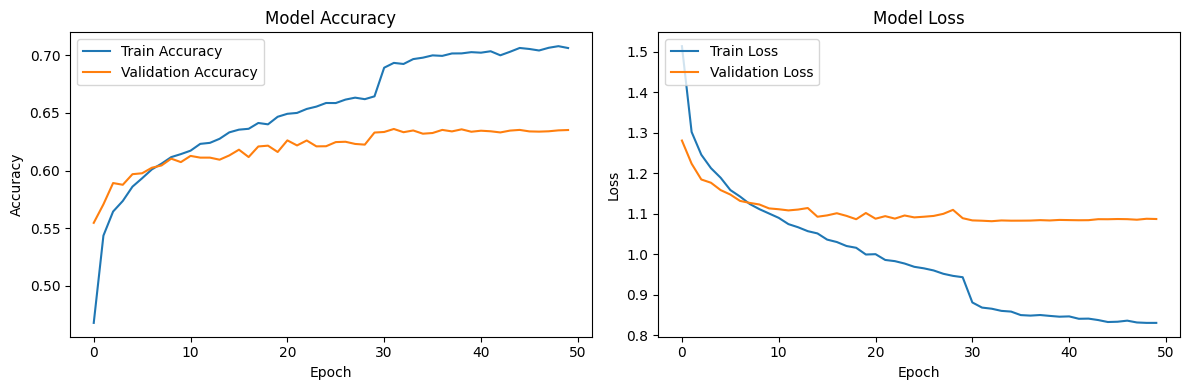

In [27]:
with open("/content/drive/My Drive/temp/training_history.pkl", 'rb') as file:
    history = pickle.load(file)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

**Save**

In [28]:
model.save('/content/drive/My Drive/temp/VGG_final.keras')

**Result**

In [29]:
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/temp/VGG_final.keras')
print("Evaluating the trained model on the test set:")
initial_loss, initial_acc = loaded_model.evaluate(X_test, y_test, verbose=1)

Evaluating the trained model on the test set:
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6324 - loss: 1.0792
